In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
df = pd.read_csv('data_gn_challenge.csv')

In [4]:
df.head()

,project_id,x,y,y2
0,6,20494.935542,0.999821,0.000179
1,6,20746.047063,0.999821,0.000179
2,6,20986.656735,0.999813,0.000187
3,6,21259.179906,0.999836,0.000164
4,6,21521.609276,0.999842,0.000158


In [5]:
df.x = df.x/85000

In [48]:
df8 = df[df.project_id == 8]
df6 = df[df.project_id == 6]
df7 = df[df.project_id == 7]
df9 = df[df.project_id == 9]
df10 = df[df.project_id == 10]
df11 = df[df.project_id == 11]

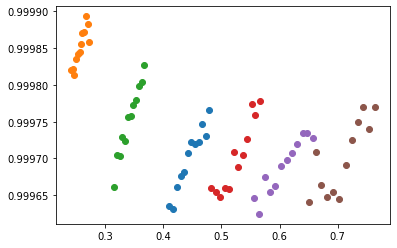

In [50]:
plt.scatter(df8.x[0:12], df8.y[0:12])
plt.scatter(df6.x[0:12], df6.y[0:12])
plt.scatter(df7.x[0:12], df7.y[0:12])
plt.scatter(df9.x[0:12], df9.y[0:12])
plt.scatter(df10.x[0:12], df10.y[0:12])
plt.scatter(df11.x[0:12], df11.y[0:12])
# plt.scatter(df8.x, df8.y)

In [9]:
def gauss_newton(X, Y, f, de_dp, P_init, P_acc):
    assert len(X) == len(Y), "The length of X and Y should match"
    assert len(de_dp) == len(P_init), "The number of parameters and partial derivatives should match"
    
    J = np.zeros(shape=(len(X), len(de_dp)))
    E = np.zeros(shape=(len(X), 1))
    
    P_cur = P_init
    
    while True:
        for i in range(len(X)):
            for j in range(len(de_dp)):
                J[i][j] = de_dp[j](P_cur, X[i])
            E[i] = Y[i] - f(P_cur, X[i])

        pinvJ = np.linalg.pinv(J)
        step = np.matmul(pinvJ, E)
        P_next = np.subtract(P_cur, step)
        P_abs_diff = np.linalg.norm(np.subtract(P_cur, P_next))
        if P_abs_diff < P_acc:
            return P_next
        P_cur = P_next 

In [104]:
# P - the vector of parameters to optimize over

def f(P, x):
    a, b, c = P
    return a * math.exp(b * (x + a)) + c

# e = y - f(P, x)
    
def de_da(P, x):
    a, b, c = P
    return - math.exp(b * (x + a)) * (a * b + 1)

def de_db(P, x):
    a, b, c = P
    return - a * (x + a) * math.exp(b * (x + a))

def de_dc(P, x):
    return -1.

The initial guess can be obtained based on 

1. the physical meaning of the parameters

2. based on the first N data points (maybe points should be taken from the middle of the dataset) an interpolation    polynomial of degree N is constructed

   using the Taylor formula, the original function approaches a polynomial of degree N
   
   equate the coefficients of the corresponding powers of the first and second polynomial
   
   a system of power equations for the coefficients of the original function is obtained
   
   solution of this system - initial guess
   
   if for a given initial guess the solution does not have the necessary convergence, we can consider points near
   the calculated initial
   
3. linearize the initial function 
    
   based on the dataset get an overdetermined system of equations for the coefficients of the original
   
   this system can be solved by numerical methods
   

before selecting the initial guess, it is necessary to conduct a qualitative assessment of the dataset and choose the most appropriate way of selection


In [203]:
# initial guess based on the interpolation polynomial
def init_guess_by_interpolation(X, Y): 
    b0 = Y[0]
    b1 = (Y[1] - Y[0])/(X[1] - X[0])
    b2 = ((Y[2] - Y[1])/(X[2] - X[1]) - b1)/(X[2] - X[0])
    D = 1 + 4 * (b1 - b2 * ( X[1] + X[0]))
    if D < 0:
        D = 0
    b = 2*b2/((-1 + math.sqrt(D))/2)
    a = ((-1 + math.sqrt(D))/2)/b
    c = b0 - b1 * X[0] + b2 * X[1] * X[0] - a**2 * b - a**3 * b**2 / 2
    return np.array([a, b, c])

In [214]:
# initial guess based on the linearization of the initial function 
def init_guess_by_linearization(X, Y):
    A = np.zeros(shape=(len(X), 3))
    b = np.zeros(shape=(len(X), 1))
    for i in range(len(X)):
        A[i][0] = X[i]
        A[i][1] = 1.
        A[i][2] = 1.
        b[i][0] = Y[i]
    
    p, q, c = np.linalg.lstsq(A, b, rcond=None)[0]
    a = p / q
    b = p / a
    return np.array([a, b, c])

In [211]:
def calc_r2(Y, Y_ans):
    y_mean = np.mean(Y)
    SS_res = 0
    SS_tot = 0
    for i in range(len(Y)):
        SS_res += (Y[i] - Y_ans[i]) ** 2
        SS_tot += (Y[i] - y_mean) ** 2
    return 1 - SS_res / SS_tot

In [202]:
X = df8.x[:12].tolist()
Y = df8.y[:12].tolist()

In [206]:
# P_init = np.array([[0.1], [-20.], [1.]])
# P_init = init_guess_by_interpolation(X[0:3], Y[0:3])
P_init = init_guess_by_linearization(X, Y)
de_dp = [de_da, de_db, de_dc]
P_acc = 1e-12
P_ans = gauss_newton(X, Y, f, de_dp, P_init, P_acc)
print(P_ans)

[[ -0.02418698]
 [-12.09386224]
 [  0.9998544 ]]


In [212]:
Y_ans = [f(P_ans, x) for x in X]
print(calc_r2(Y, Y_ans))

[0.94970767]


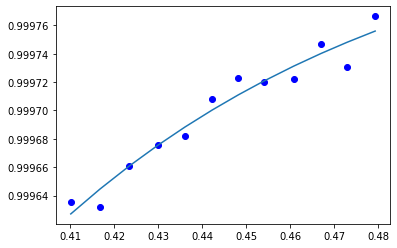

In [213]:
plt.scatter(X, Y, color='blue')
plt.plot(X, Y_ans, '-')